# Logistic Regression

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In this lab, we are exploring crimes reported in Chicago in 2019. We will use this data to explore the context of logistic regression.

In [2]:
df = pd.read_csv("../data/chicago-crimes-2019.csv.gz", compression='gzip')
df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11922110,JC547456,12/15/2019 03:40:00 AM,039XX W NORTH AVE,1020,ARSON,BY FIRE,VEHICLE NON-COMMERCIAL,False,False,...,26.0,23.0,09,1149951.0,1910348.0,2019,04/27/2020 03:48:23 PM,41.909907,-87.724578,"(41.909907002, -87.724577987)"
1,11918688,JC543281,12/11/2019 01:20:00 PM,045XX S WESTERN AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,PARKING LOT / GARAGE (NON RESIDENTIAL),True,False,...,15.0,61.0,26,1161131.0,1874302.0,2019,04/27/2020 03:48:23 PM,41.810768,-87.684508,"(41.810768138, -87.684507864)"
2,11896637,JC516819,11/19/2019 06:36:00 PM,012XX S SPAULDING AVE,031A,ROBBERY,ARMED - HANDGUN,SIDEWALK,False,False,...,24.0,29.0,03,1154560.0,1894222.0,2019,04/27/2020 03:48:23 PM,41.865565,-87.708078,"(41.865564662, -87.708077974)"
3,11845710,JC453753,09/30/2019 04:10:00 AM,048XX W CORTEZ ST,0265,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,RESIDENCE,True,True,...,37.0,25.0,02,1143935.0,1906545.0,2019,04/27/2020 03:48:23 PM,41.899586,-87.746774,"(41.89958619, -87.746774067)"
4,11827810,JC432624,09/14/2019 01:25:00 AM,039XX W JACKSON BLVD,041A,BATTERY,AGGRAVATED - HANDGUN,STREET,False,False,...,28.0,26.0,04B,1150182.0,1898397.0,2019,04/27/2020 03:48:23 PM,41.877108,-87.724041,"(41.877107715, -87.724041149)"


## Feature Engineering

First, we will clean up some features, and then create a new dataframe that has arrests and incidents by hour. From that data, we can compute arrest probability, as well as a time-shifted hour of the day, which seems to correlate better with the data.

In [3]:
df['Arrest'] = df['Arrest'].astype(int)
df['hour'] = pd.to_datetime(df['Date']).dt.hour

In [5]:
# Number of Arrests per hour
arrest_hour = pd.DataFrame(df.groupby(['hour'])['Arrest'] \
                                              .sum() \
                                              .reset_index(name='arrests') \
                                              .sort_values(['hour'], ascending=True))

# Number of Incidents per hour
all_hour = pd.DataFrame(df.groupby(['hour'])['ID'] \
                                              .count() \
                                              .reset_index(name='incidents') \
                                              .sort_values(['hour'], ascending=True))

# New Dataframe
adf = pd.merge(arrest_hour,all_hour,on=['hour'])
adf['prob'] = adf['arrests'] / adf['incidents']
adf

,hour,arrests,incidents,prob
0,0,2264,12467,0.181599
1,1,1769,7942,0.222740
2,2,1340,6922,0.193586
3,3,975,5481,0.177887
4,4,659,4407,0.149535
5,5,477,3827,0.124641
6,6,692,4408,0.156987
7,7,959,6174,0.155329
8,8,1448,8901,0.162678
9,9,1967,11524,0.170687


A look at this data shows that the probability of reported crimes resulting in arrest drops in the early morning hours (i.e., from 3-9 a.m.). We engineer some features based on this observation: (1) the probability of crimes resulting in arrest exceeding a threshold, and shifted hours of the day, that run 3 a.m. to 2:59 a.m.

In [6]:
# This is a derived binary variable that is "toy" for the sake of illustration.
adf['pthresh'] = adf['prob'] > 0.18
adf['hrs'] = (adf['hour'] + 21) % 24
adf

,hour,arrests,incidents,prob,pthresh,hrs
0,0,2264,12467,0.181599,True,21
1,1,1769,7942,0.222740,True,22
2,2,1340,6922,0.193586,True,23
3,3,975,5481,0.177887,False,0
4,4,659,4407,0.149535,False,1
5,5,477,3827,0.124641,False,2
6,6,692,4408,0.156987,False,3
7,7,959,6174,0.155329,False,4
8,8,1448,8901,0.162678,False,5
9,9,1967,11524,0.170687,False,6


## Create Pipelines

Below, we create the features for our model, and a pipeline for performing a logistic regression. We show a standard logistic regression, as well as one with cross-validation.

In [7]:
# Features for fitting the model.
x = adf['hrs'].astype('float').values.reshape(-1,1)
y = adf['pthresh']
z = np.arange(0.,24.,1).reshape(-1, 1);

In [8]:
penalty='l2'
C = 10
solver='lbfgs'

pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('logr', LogisticRegression(penalty=penalty, 
                                C=C,
                                solver=solver))
])

pipelineCV = Pipeline([
    ('norm', StandardScaler()),
    ('logr', LogisticRegressionCV(penalty=penalty,
                                  class_weight='balanced',
                                  Cs=C,
                                  cv=3,
                                  random_state=0,
                                  solver=solver)),
])

## Prediction

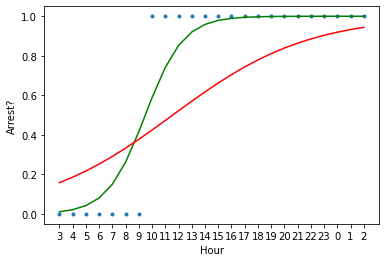

In [9]:
pipeline.fit(x,y)
line = pipeline.predict_proba(z)[:,1]

pipelineCV.fit(x,y)
lineCV = pipelineCV.predict_proba(z)[:,1]

hours = adf['hour'][3:].append(adf['hour'][0:3])
plt.xticks(np.arange(24),hours)
plt.xlabel('Hour')
plt.ylabel('Arrest?')
plt.plot(x,y,'.')
plt.plot(z, line, color='green')
plt.plot(z, lineCV, color='red')
plt.show()

---

## Live Class Data Exploration

In [ ]:
df['datetime'] = pd.to_datetime(df['Date'])

In [ ]:
df['minute'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute
df['second'] = df['minute'] * 60 + df['datetime'].dt.second
df

In [ ]:
# Number of Arrests per hour
arrest_second = pd.DataFrame(df.groupby(['second'])['Arrest'] \
                                              .sum() \
                                              .reset_index(name='arrests') \
                                              .sort_values(['second'], ascending=True))

# Number of Incidents per hour
all_second = pd.DataFrame(df.groupby(['second'])['ID'] \
                                              .count() \
                                              .reset_index(name='incidents') \
                                              .sort_values(['second'], ascending=True))


# New Dataframe
adf2 = pd.merge(arrest_second,all_second,on=['second'])
adf2['prob'] = adf2['arrests'] / adf2['incidents']
adf2

In [ ]:
x = adf2['second']
y = adf2['prob'] > 0.18
plt.xlabel('Second')
plt.ylabel('Arrest?')
plt.plot(x,y,'.')
#plt.plot(z, line, color='green')
#plt.plot(z, lineCV, color='red')
plt.show()